In [74]:
import mysql.connector

config = {
    'host': '127.0.0.1',
    'user': 'root',
    'password': 'xuhengda',
    'database': 'BOOSTDB',
}
cnx = mysql.connector.connect(**config)
print(cnx)

# [前端] 注册BOT_ID
* 写BOTS表

In [15]:
bot_id = '0'
cursor = cnx.cursor()
sql = 'INSERT INTO BOTS (BOT_ID) VALUES (%s)'
data = (bot_id,)
cursor.execute(sql, data)
cnx.commit()
cursor.close()

True

# [前端] 把csv文件存入数据库
* 写UTTERANCES表
* 用时较长（待优化）
* INSERT次数太多

In [18]:
import csv

cursor = cnx.cursor()
csv_file = 'chat.csv'
with open(csv_file, encoding='utf-8') as f:
    reader = csv.reader(f, delimiter=',')
    sql = ('INSERT INTO UTTERANCES (BOT_ID, CONV_ID, SPEAKER_ID, UTTERANCE) '
           'VALUES (%s, %s, %s, %s)')
    for conv_id, speaker_id, utterance in reader:
        data = [bot_id, int(conv_id), int(speaker_id), utterance]
        cursor.execute(sql, data)
cnx.commit()
cursor.close()

True

# [后端] 读数据
* 读UTTERANCES表
* 写CONVS表

In [49]:
cursor = cnx.cursor()

sql = 'SELECT CONV_ID, UTTERANCE FROM UTTERANCES WHERE BOT_ID = %s'
data = (bot_id,)
cursor.execute(sql, data)

corpus = []
conv = ''
last_conv_id = None
for conv_id, utterance in cursor:
    if conv_id != last_conv_id:
        corpus.append(conv[:len(conv) - 1])
        conv = ''
        last_conv_id = conv_id
    else:
        conv += utterance + ' '
corpus.append(conv[:len(conv) - 1])
corpus = corpus[1:]
cursor.close()

print(len(corpus), 'conversations', end='\n\n')
print(corpus[0])

cursor = cnx.cursor()
sql = 'SELECT DISTINCT CONV_ID FROM UTTERANCES WHERE BOT_ID = %s'
data = (bot_id,)
cursor.execute(sql, data)
conv_ids = list(map(lambda t: int(t[0]), cursor))

sql = 'INSERT INTO CONVS (CONV_ID, BOT_ID) VALUES '
sql_value = '(%s, %s), ' * len(conv_ids)
sql += sql_value[:-2]
data = []
for conv_id in conv_ids:
    data.append(conv_id)
    data.append(bot_id)
cursor.execute(sql, data)
cnx.commit()
cursor.close()

10942 conversations

请您稍等一下，正在为您核实处理中哦~ 有什么问题我可以帮您处理或解决呢? 宠物天然粮[姓名x]犬成犬狗粮[数字x]kg 对的。 这款商品库房还没有到货’ 什么时候能到货啊? 可以给您操作有货的先发 零食那个有货呗? 狗粮一袋都没有么? 有的话都给我先发吧。 ? 稍等哈 恩 查询以操作了有货先发 您的订单现在是两个订单 建议您关注一下订单的物流信息哈 狗粮啥时候能有货? 预计一周左右 好吧，希望快点发货 好的亲 请问还有其他还可以帮到您的吗?


True

# [后端] 数据清洗

In [51]:
import jieba
import logging
import re
import time

jieba.setLogLevel(logging.INFO)
logging.basicConfig(format='%(funcName)s:%(message)s', level=logging.DEBUG)

stop_wrods_file = 'stop_words.txt'

def _substitute(sent):
    exps = [
        r'#E-\w\[数字x\]|~O\(∩_∩\)O/~',
        r'http[s]?://[a-zA-Z0-9|\.|/]+',
        r'http[s]?://[a-zA-Z0-9\./-]*\[链接x\]',
        r'\[ORDERID_[0-9]+\]',
        r'\[日期x\]',
        r'\[时间x\]',
        r'\[金额x\]',
        r'\[站点x\]',
        r'\[数字x\]',
        r'\[地址x\]',
        r'\[姓名x\]',
        r'\[邮箱x\]',
        r'\[电话x\]',
        r'\[商品快照\]',
        r'<s>',
        r'\s+',
        r'[a-z|0-9]+'
        "[\s+\.\!\/_,$%^:*(+\"\')]+",
        "[+——()?:【】‘’“”`！，。？、~@#￥%……&*（）]+"
    ]
    for exp in exps:
        sent = re.sub(exp, ' ', sent)
    return sent


logging.info('数据清洗开始...')

# 正则表达式替换特定字符串
corpus = list(map(_substitute, corpus))
logging.info('正则表达式替换完成.')

# 分词
t = time.time()
corpus = list(map(jieba.cut, corpus))
logging.info('分词完成.')

# 删除停用词
logging.info('删除停用词开始...')
with open(stop_wrods_file, encoding='utf-8') as f:
    stop_words = f.read().strip().split('\n')

t = time.time()
for i in range(len(corpus)):
    tokens = []
    for token in corpus[i]:
        token = token.strip()
        if len(token) > 1 and token not in stop_words:
            tokens.append(token)
    corpus[i] = tokens
logging.info('删除停用词完成 (用时: %.2fs).' % (time.time() - t))

# 组合
corpus = list(map(lambda x: ' '.join(x), corpus))

logging.info('数据清洗完成.')

<module>:数据清洗开始...
<module>:正则表达式替换完成.
<module>:分词完成.
<module>:删除停用词开始...
<module>:删除停用词完成 (用时: 18.37s).
<module>:数据清洗完成.


# [后端] TFIDF
* 写WORDS表

In [56]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

max_df = 0.1
min_df = 20
max_features = 1000

tfidf_vectorizer = TfidfVectorizer(max_df=max_df,
                                   min_df=min_df,
                                   max_features=max_features)
tfidf = tfidf_vectorizer.fit_transform(corpus)

# 获取每个词的df值
idf = tfidf_vectorizer.idf_
df = list(map(lambda x: (len(corpus) + 1) / np.exp(x - 1) - 1, idf))
df = list(map(lambda x: x / len(corpus), df))

words = tfidf_vectorizer.get_feature_names()

cursor = cnx.cursor()
sql = 'INSERT INTO WORDS (WORD_ID, BOT_ID, WORD, DF) VALUES '
sql_values = '(%s, %s, %s, %s), ' * len(words)
sql += sql_values[:-2]
data = []
for (word_id, (word, df)) in enumerate(zip(words, df)):
    data.extend([word_id, bot_id, word, df])
cursor.execute(sql, data)
cnx.commit()
cursor.close()

True

# [前端] 读DF
* 读WORDS表

wrapper:CACHEDIR=/Users/dada/.matplotlib
<module>:Using fontManager instance from /Users/dada/.matplotlib/fontList.json
pylab_setup:backend module://ipykernel.pylab.backend_inline version unknown
pylab_setup:backend module://ipykernel.pylab.backend_inline version unknown


total words: 1000
文件频率df-词数


findfont:findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0 to DejaVu Sans ('/Users/dada/anaconda3/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000


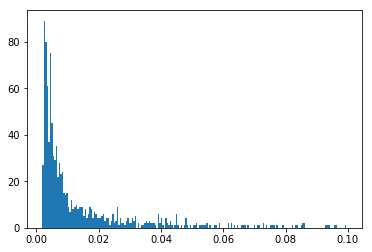

每个词的文件频率df


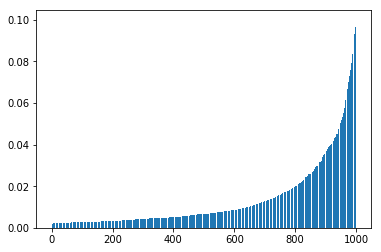

pylab_setup:backend module://ipykernel.pylab.backend_inline version unknown


In [58]:
import matplotlib.pyplot as plt
%matplotlib inline

cursor = cnx.cursor()
sql = 'SELECT DF FROM WORDS WHERE BOT_ID = %s ORDER BY DF ASC'
data = (bot_id,)
cursor.execute(sql, data)
df = list(map(lambda t: float(t[0]), cursor))
cursor.close()

print('total words:', len(df))

print('文件频率df-词数')
plt.hist(df, 200)
plt.show()

print('每个词的文件频率df')
df.sort()
plt.bar(np.arange(len(df)), df)
plt.show()

# [后端] 聚类

In [59]:
from sklearn.cluster import KMeans

n_clusters = 50
max_iter=100

kmeans = KMeans(n_clusters=n_clusters,
                    max_iter=max_iter,
                    n_init=8,
                    init='k-means++',
                    n_jobs=-1,
                    random_state=0,
                    verbose=1)
labels = kmeans.fit_predict(tfidf)

Initialization complete
Iteration  0, inertia 10513.378
Iteration  1, inertia 9614.311
Iteration  2, inertia 9303.038
Iteration  3, inertia 9157.904
Iteration  4, inertia 9094.439
Iteration  5, inertia 9054.545
Iteration  6, inertia 9023.396
Iteration  7, inertia 9004.487
Iteration  8, inertia 8995.578
Iteration  9, inertia 8990.030
Iteration 10, inertia 8984.716
Iteration 11, inertia 8981.349
Iteration 12, inertia 8979.138
Iteration 13, inertia 8977.539
Iteration 14, inertia 8976.174
Iteration 15, inertia 8974.211
Iteration 16, inertia 8971.560
Iteration 17, inertia 8969.079
Iteration 18, inertia 8967.815
Iteration 19, inertia 8967.393
Iteration 20, inertia 8967.214
Iteration 21, inertia 8967.144
Iteration 22, inertia 8967.099
Iteration 23, inertia 8967.043
Iteration 24, inertia 8966.970
Iteration 25, inertia 8966.721
Iteration 26, inertia 8966.581
Iteration 27, inertia 8966.564
Iteration 28, inertia 8966.529
Iteration 29, inertia 8966.498
Iteration 30, inertia 8966.477
Iteration 31, 

Iteration 28, inertia 8737.777
Iteration 29, inertia 8737.690
Iteration 30, inertia 8737.564
Iteration 31, inertia 8737.406
Iteration 32, inertia 8737.261
Iteration 33, inertia 8737.142
Iteration 34, inertia 8736.909
Iteration 35, inertia 8736.557
Iteration 36, inertia 8736.282
Iteration 37, inertia 8736.041
Iteration 38, inertia 8735.720
Iteration 39, inertia 8735.174
Iteration 40, inertia 8734.690
Iteration 41, inertia 8734.584
Iteration 42, inertia 8734.544
Converged at iteration 42: center shift 0.000000e+00 within tolerance 9.735164e-08


# [后端]  计算CH指数
* 写BOTS表

In [62]:
from sklearn import metrics

ch = metrics.calinski_harabaz_score(tfidf.toarray(), labels)
print('CH: %.3f' % ch)

cursor = cnx.cursor()
sql = 'UPDATE BOTS SET CH = %s WHERE BOT_ID = %s'
data = (ch, bot_id)
cursor.execute(sql, data)
cnx.commit()
cursor.close()

CH: 48.803


True

# [前端] 查询CH指数
* 读BOTS表

In [63]:
cursor = cnx.cursor()
sql = 'SELECT CH FROM BOTS WHERE BOT_ID = %s'
data = (bot_id,)
cursor.execute(sql, data)
ch = float(cursor.fetchone()[0]) 
cursor.close()

print('CH: %.3f' % ch)

CH: 48.803


# [后端] 记录每段对话写类别标签
* 写CONVS表
* 多次UPDATE（待优化）

In [64]:
cursor = cnx.cursor()
sql = 'UPDATE CONVS SET CLUSTER_ID = %s WHERE BOT_ID = %s AND CONV_ID = %s'
for conv_id, cluster_id in enumerate(labels):
    data = (int(cluster_id), bot_id, conv_id)
    cursor.execute(sql, data)
cnx.commit()
cursor.close()

True

# [后端] 记录每个簇的对话数量
* 写CLUSTERS表

In [76]:
counts = [(labels == idx).sum() for idx in range(n_clusters)]
cursor = cnx.cursor()
sql = 'INSERT INTO CLUSTERS (CLUSTER_ID, BOT_ID, VOLUME) VALUES'
sql_values = ' (%s, %s, %s),' * n_clusters
sql += sql_values[:-1]
data = []
for cluster_id, volume in enumerate(counts):
    data.extend([cluster_id, bot_id, int(volume)])
cursor.execute(sql, data)
cnx.commit()
cursor.close()

True

# [前端] 查询每个簇中对话的数量
* 读CLUSTERS表

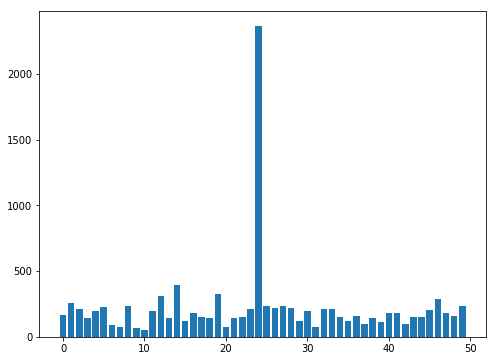

In [77]:
cursor = cnx.cursor()
sql = 'SELECT VOLUME FROM CLUSTERS WHERE BOT_ID = %s'
data = (bot_id,)
cursor.execute(sql, data)
volumes = [vol for (vol,) in cursor]
cursor.close()

plt.figure(figsize=(8, 6))
plt.bar(range(n_clusters), volumes)
plt.show()

# [后端] 计算每个簇的关键词
* 写CLUSTER_KEYWORDS表

In [84]:
cursor = cnx.cursor()

td = list(map(lambda x: x.toarray().squeeze(), tfidf))
    
vectorss = [[] for _ in range(n_clusters)]
for i in range(len(corpus)):
    vectorss[labels[i]].append(td[i])
    
terms = tfidf_vectorizer.get_feature_names()
    
for cluster_id, vectors in enumerate(vectorss):
    vectors = np.array(vectors)
    vectors = vectors.sum(0)
    num = (vectors != 0.0).sum()
    word_ids = vectors.argsort()[:-1-num:-1]
    
    sql = 'INSERT INTO CLUSTER_KEYWORDS (BOT_ID, CLUSTER_ID, WORD_ID, TFIDF) VALUES'
    sql_values = ' (%s, %s, %s, %s),' * len(word_ids)
    sql += sql_values[:-1]
    data = []
    for word_id in word_ids:
        data.extend((bot_id, cluster_id, int(word_id), float(vectors[word_id])))
    cursor.execute(sql, data)
cnx.commit()
cursor.close()

True

# [前端] 展示每个簇的关键词
* 联合查询CLUSTER_KEYWORDS和WORDS

cluster #0: 实在 久等 耽误 谅解 放心 为止 直到 跟进 真的 灰常 签收 这么久 不便 通知 造成 催促 几分钟 着急 人数 物流 手中 送到



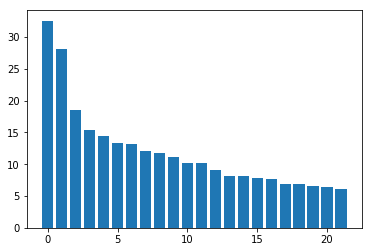

cluster #1: 送到 加急 稍等一下 通知 跟踪 物流 手中 催下 放心 更新 到达 不到 一定 到货 昨天 下午 知道 目前 关注 安排 上午 确定



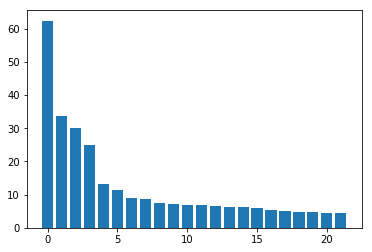

cluster #2: 换货 实体店 质量 更换 只能 审核 衣服 型号 维修 之家 退换 备注 上门 价格 建议 安排 建议您 改成 修改 之内 无法 购买



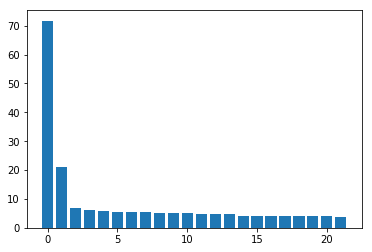

cluster #3: 维修 质保 联保 期为 服务 全国 产品 享受 三包 保修 返厂 超出 返回 检测 周期 一年 客户服务 承担 包装 质量 返修 左右



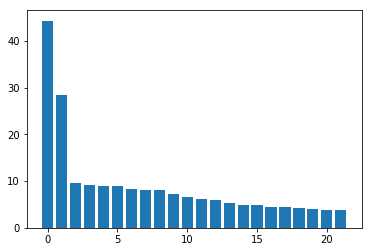

cluster #4: 工作日 微信 储蓄卡 零钱 信用卡 支付 白条 时效 余额 退回 差价 现金支付 返还 账户 红包 两个 30 注意 优惠券 额度 恢复 审核



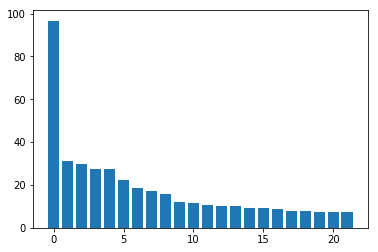

True

In [85]:
cursor = cnx.cursor()
sql = ('SELECT WORDS.WORD, CLUSTER_KEYWORDS.TFIDF '
       'FROM CLUSTER_KEYWORDS INNER JOIN WORDS '
       'WHERE CLUSTER_KEYWORDS.WORD_ID = WORDS.WORD_ID '
       'AND WORDS.BOT_ID = %s AND CLUSTER_KEYWORDS.BOT_ID = WORDS.BOT_ID '
       'AND CLUSTER_ID = %s '
       'ORDER BY CLUSTER_KEYWORDS.TFIDF DESC')

for cluster_id in range(5):
    data = (bot_id, cluster_id)
    cursor.execute(sql, data)

    words = []
    values = []
    for word_id, value in cursor:
        words.append(word_id)
        values.append(float(value))

    num = 22
    print('cluster #%d:' % cluster_id, ' '.join(words[:num]), end='\n\n')
    plt.bar(range(num), values[:num])
    plt.show()
cursor.close()

# [前端] 查看指定簇
* 联合查询CLUSTER_KEYWORDS和WORDS
* 联合查询CONVS和UTTERANCES

cluster #4: 工作日 微信 储蓄卡 零钱 信用卡 支付 白条 时效 余额 退回 差价 现金支付 返还 账户 红包 两个 30 注意 优惠券 额度 恢复 审核



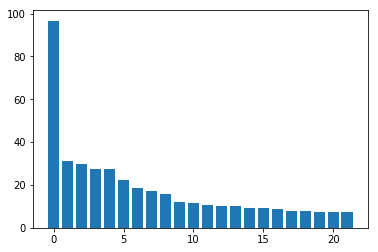


1 请问您是咨询之前的问题还是有其他的问题需要处理呢?
0 之前的
1 请您稍等一下，正在为您核实处理中哦~
0 可以了吗 怎么这么慢的京东
1 订单编号:[ORDERID_10003532] 这个吗
0 对
1 您是要取消吗
0 不要了
1 邮件主题:京保养客户退款单+订单号
0 现在总算有说法了 失望
1 还请您消消气 我们还会改进的哈
0 已经发送了
1 会在[数字x]个工作日处理的哈 因为什么原因呢 我在给您发一遍邮箱 给您督促处理
0 好的 不方便
1 您提供一下
0 [姓名x] [数字x]款
1 好的 我给您在督促一下哈
0 谢谢
1 您客气了哈 处理时效[数字x]个工作日 您会收到短信提示的哈 请问还有其他还可以帮到您的吗?
0 那应该能成功的是吧
1 嗯
0 谢谢

1 跨区了吗
0 南山换到民治 跨了 同一个城市
1 建议您取消订单重新下单哈 也是需要到达站点后再转战的呢 妹子看您是刚下单的呢
0 是 我看到今天不能到
1 您可以取消后重新下单哦
0 但我明天不上班
1 妹子不敢保证具体时间的呢，如果修改地址的话更是需要一些时间的呢
0 取消的退款什么时候到账呢
1 您好，商品退回后会开始办理退款，退款后也会有提示，退款周期:储蓄卡[数字x]-[数字x]工作日，信用卡[数字x]-[数字x][数字x]工作日，POS机刷卡[数字x]-[数字x][数字x]工作日，邮局汇款退储蓄卡[数字x]-[数字x]工作日，支票退款[数字x]-[数字x]工作日，分期付款[数字x]-[数字x][数字x]工作日，微信银行卡，退款[数字x]-[数字x][数字x]个工作日，现金支付是退回京东账户余额，[数字x]-[数字x]工作日左右。
0 谢谢??

1 请问有什么可以帮您? 亲爱的客户，还麻烦您提供下订单号，妹子这边给您查询哦~
0 [ORDERID_10005924]
1 配送退货
0 好的
1 您好，商品退回后会开始办理退款，退款后也会有提示，退款周期:储蓄卡[数字x]-[数字x]工作日，信用卡[数字x]-[数字x][数字x]工作日，POS机刷卡[数字x]-[数字x][数字x]工作日，邮局汇款退储蓄卡[数字x]-[数字x]工作日，支票退款[数字x]-[数字x]工作日，分期付款[数字x]-[数字x][数字x]工作日，微信银行卡，退款[数字x]-[数字x][数字x]个工作日

True

In [93]:
cursor = cnx.cursor()

cluster_id = 4

sql = ('SELECT WORDS.WORD, CLUSTER_KEYWORDS.TFIDF '
       'FROM CLUSTER_KEYWORDS INNER JOIN WORDS '
       'WHERE CLUSTER_KEYWORDS.WORD_ID = WORDS.WORD_ID '
       'AND WORDS.BOT_ID = %s AND CLUSTER_KEYWORDS.BOT_ID = WORDS.BOT_ID '
       'AND CLUSTER_ID = %s '
       'ORDER BY CLUSTER_KEYWORDS.TFIDF DESC')
data = (bot_id, cluster_id)
cursor.execute(sql, data)

words = []
values = []
for word_id, value in cursor:
    words.append(word_id)
    values.append(float(value))

num = 22
print('cluster #%d:' % cluster_id, ' '.join(words[:num]), end='\n\n')
plt.bar(range(num), values[:num])
plt.show()


sql = ('SELECT CONVS.CONV_ID, SPEAKER_ID, UTTERANCE '
       'FROM CONVS INNER JOIN UTTERANCES '
       'WHERE CONVS.BOT_ID = %s AND UTTERANCES.BOT_ID = CONVS.BOT_ID '
       'AND CONVS.CONV_ID = UTTERANCES.CONV_ID '
       'AND CLUSTER_ID = %s')
data = (bot_id, cluster_id)
cursor.execute(sql, data)

last_conv_id = None
conv = ''
count = 0
for conv_id, speaker_id, utterance in cursor:
    if conv_id == last_conv_id:
        conv += str(speaker_id) + ' ' + utterance + '\n'
    else:
        print(conv)
        last_conv_id = conv_id
        conv = ''
        count += 1
        if count >= 5:
            break

cursor.fetchall()
cursor.close()